In [17]:
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [23]:
import tensorflow as tf
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import numpy as np


Start-off talk

11490434/11490434 [==============================] - 1s 0us/step
Training data: X=(60000, 28, 28), Y=(60000,)
Testing data: X=(10000, 28, 28), Y=(10000,)


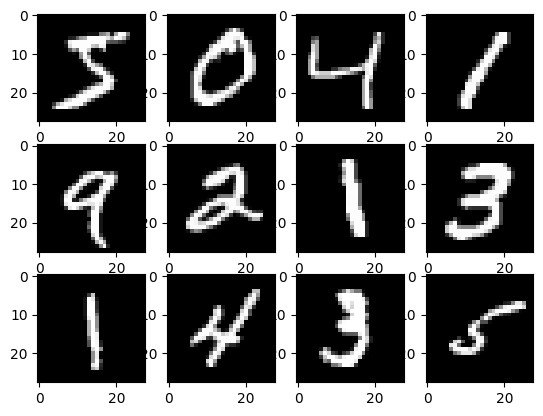

In [24]:
#loading dataset
train, test = tf.keras.datasets.mnist.load_data()
(trainX, trainY) = train
(testX, testY) = test

print('Training data: X=%s, Y=%s' % (trainX.shape, trainY.shape))
print('Testing data: X=%s, Y=%s' % (testX.shape, testY.shape))


# displaying the dataset
for i in range(12):
    # define subplot
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))

plt.show()

As we can see, the MNIST dataset is comprised entirely of handwritten numerical digits, 0 through 9. I'll be using a convolutional neural network (CNN) here to create a model that views a piece of writing and predicts what digit is shown.

Since they're all black and white, we can put them all into one color channel.

We can then put each sample into a single hot encoding. Each point will have a binary vector of 10, with 1 for the class value and 0 for all the other values. So, if the number is 3, it'll still print 3, but it'll be programed like this:

```{0, 0, 0, 1, 0, 0, 0, 0, 0, 0}```

After that, we'll need to turn the training and test input data from integers ranging [0, 255] to floats ranging [0, 1].

In [45]:
#putting it together into a handy function
def mnist_load():
  train, test = tf.keras.datasets.mnist.load_data()
  (trainX, trainY) = train
  (testX, testY) = test

  # reshaping the dataset
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # all hots to encode target values
  trainY = tf.keras.utils.to_categorical(trainY)
  testY = tf.keras.utils.to_categorical(testY)

  # scaling the pixels
  trainX = trainX.astype('float32') / 255.0
  testX = testX.astype('float32') / 255.0
  # ex. 173 -> .678431...

  return trainX, trainY, testX, testY

Now to start on the model. I'll use one (3, 3) convolutional layer and a changeable number of filters, ending with a max pooling layer. The learning rate and momentum will also be changeable. This allows for comparison on how differently set-up models will perform.

In [47]:
def mnist_model(filters, learning_rate, momentum):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  #model compilation
  opt = tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=momentum)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [30]:
mnist_model(48, 0.008, 0.9)

Now we'll create the function for evaluating the model. We'll be using a k-fold here.

In [64]:
# Uses a k-fold to evaluate the model
# k-fold divides the testing data into n number of folds, each one taking turns
# being the testing data.
def evaluate_model(trainX, trainY, filters, learning_rate, momentum, n_folds=5):
	scores = []
	histories = []
	# creates n number of kfolds, shuffling the data
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# assigns the training and testing data
	for train_ix, test_ix in kfold.split(trainX):
		# constructs the model
		model = mnist_model(filters, learning_rate, momentum)
		# select rows for each mindpoint training and testing session
		trainx = trainX[train_ix]
		trainy = trainY[train_ix]
		testx = trainX[test_ix]
		testy = trainY[test_ix]
		# fit model
		history = model.fit(trainx, trainy, epochs=10, batch_size=32, validation_data=(testx, testy), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testx, testy, verbose=0)
		print('>%.2f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


In [63]:
kfold = KFold(5, shuffle=True, random_state=1)

for train_ix, test_ix in kfold.split(trainX):
  print(train_ix, test_ix)

[    0     1     2 ... 59997 59998 59999] [   10    12    28 ... 59967 59968 59971]
[    0     1     4 ... 59997 59998 59999] [    2     3     8 ... 59976 59984 59994]
[    1     2     3 ... 59995 59998 59999] [    0    21    22 ... 59993 59996 59997]
[    0     2     3 ... 59997 59998 59999] [    1     4     5 ... 59990 59991 59995]
[    0     1     2 ... 59995 59996 59997] [    9    14    15 ... 59989 59998 59999]


Special thanks to Jason Brownlee for help.